In [41]:
using LinearAlgebra

In [1]:
text = "You say goodbye and I say hello."

"You say goodbye and I say hello."

In [4]:
text = lowercase(text)

"you say goodbye and i say hello."

In [8]:
text = replace(text, "." => " .")

"you say goodbye and i say hello ."

In [9]:
words = split(text, " ")

8-element Array{SubString{String},1}:
 "you"    
 "say"    
 "goodbye"
 "and"    
 "i"      
 "say"    
 "hello"  
 "."      

In [21]:
word_to_id = Dict{String, Int}()
id_to_word = Dict{Int, String}()
for word in words
    word = String(word)
    if !haskey(word_to_id, word)
        new_id = length(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
    end
end
@show word_to_id;
@show id_to_word;

word_to_id = Dict("say"=>1,"goodbye"=>2,"you"=>0,"hello"=>5,"."=>6,"and"=>3,"i"=>4)
id_to_word = Dict(0=>"you",4=>"i",2=>"goodbye",3=>"and",5=>"hello",6=>".",1=>"say")


In [22]:
id_to_word[1]

"say"

In [23]:
word_to_id["hello"]

5

In [24]:
corpus = [word_to_id[String(w)] for w in words]

8-element Array{Int64,1}:
 0
 1
 2
 3
 4
 1
 5
 6

In [34]:
function preprocess(text)
    text = lowercase(text)
    text = replace(text, "." => " .")
    words = split(text, " ")
    word_to_id = Dict{String, Int}()
    id_to_word = Dict{Int, String}()
    for word in words
        word = String(word)
        if !haskey(word_to_id, word)
            new_id = length(word_to_id) + 1
            word_to_id[word] = new_id
            id_to_word[new_id] = word
        end
    end
    corpus = [word_to_id[String(w)] for w in words]
    return corpus, word_to_id, id_to_word
end

preprocess (generic function with 1 method)

In [35]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

([1, 2, 3, 4, 5, 2, 6, 7], Dict("say"=>2,"goodbye"=>3,"you"=>1,"hello"=>6,"."=>7,"and"=>4,"i"=>5), Dict(7=>".",4=>"and",2=>"say",3=>"goodbye",5=>"i",6=>"hello",1=>"you"))

In [38]:
function create_co_matrix(corpus, vocab_size; window_size=1)
    corpus_size = length(corpus)
    co_matrix = zeros(Int64, vocab_size, vocab_size)
    
    for (idx, word_id) in enumerate(corpus)
        for i in 1:window_size
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 1
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            end
                
            if right_idx <= corpus_size
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
            end
        end
    end
    
    return co_matrix
end

create_co_matrix (generic function with 1 method)

In [42]:
C = create_co_matrix(corpus, 7)

7×7 Array{Int64,2}:
 0  1  0  0  0  0  0
 1  0  1  0  1  1  0
 0  1  0  1  0  0  0
 0  0  1  0  1  0  0
 0  1  0  1  0  0  0
 0  1  0  0  0  0  1
 0  0  0  0  0  1  0

In [40]:
function cos_similarity(x, y; ϵ=1e-8)
    nx = x ./ sqrt(sum(x .^ 2) + ϵ)
    ny = y ./ sqrt(sum(y .^ 2) + ϵ)
    return dot(nx, ny)
end

cos_similarity (generic function with 1 method)

In [49]:
c0 = C[word_to_id["you"], :];
c1 = C[word_to_id["i"], :];
println(cos_similarity(c0, c1))

0.7071067758832467


In [56]:
function most_similiar(query, word_to_id, id_to_word, word_matrix; top=5)
    if !haskey(word_to_id, query)
        println("$query is not found")
        return
    end
    
    # 1. get query info
    println("\n[$query]")
    qid = word_to_id[query]
    qvec = word_matrix[qid, :]
    
    # 2. compute cosine similarity
    vocab_size = length(id_to_word)
    similarity = zeros(vocab_size)
    for i in 1:vocab_size
        similarity[i] = cos_similarity(word_matrix[i, :], qvec)
    end
    
    # 3. print up to 'top' words
    count = 0
    for i in sortperm(-1 .* similarity)
        if id_to_word[i] == query
            continue
        end
        println("  $(id_to_word[i]): $(similarity[i])")
        count += 1
        if count >= top
            return
        end
    end
end

most_similiar (generic function with 1 method)

In [58]:
most_similiar("you", word_to_id, id_to_word, C, top=5)


[you]
  goodbye: 0.7071067758832467
  i: 0.7071067758832467
  hello: 0.7071067758832467
  say: 0.0
  and: 0.0


In [59]:
function PPMI(C; verbose=false, ϵ=1e-8)
    M = zeros(Float64, size(C))
    N = sum(C)
    S = sum(C, dims=1)
    total = size(C)[1] * size(C)[2]
    count = 0
    
    for i in 1:size(C)[1]
        for j in 1:size(C)[2]
            pmi = log2(C[i, j] * N / (S[j] * S[i]) + ϵ)
            M[i, j] = max(0, pmi)
            
            if verbose
                count += 1
                if count % (total // 100) == 0
                    println("$(100 * cnt / total) done")
                end
            end
        end
    end
    
    return M
end

PPMI (generic function with 1 method)

In [61]:
W = PPMI(C)

7×7 Array{Float64,2}:
 0.0      1.80735   0.0       0.0      0.0       0.0       0.0    
 1.80735  0.0       0.807355  0.0      0.807355  0.807355  0.0    
 0.0      0.807355  0.0       1.80735  0.0       0.0       0.0    
 0.0      0.0       1.80735   0.0      1.80735   0.0       0.0    
 0.0      0.807355  0.0       1.80735  0.0       0.0       0.0    
 0.0      0.807355  0.0       0.0      0.0       0.0       2.80735
 0.0      0.0       0.0       0.0      0.0       2.80735   0.0    

In [62]:
U, S, V = svd(W)

SVD{Float64,Float64,Array{Float64,2}}([0.340949 2.22045e-16 … -0.932325 -4.38419e-17; -1.11022e-16 -0.597636 … 2.22045e-16 1.2326e-32; … ; 0.709237 2.34281e-17 … 0.170959 -5.20488e-17; 3.33067e-16 -0.628489 … -3.33067e-16 2.68919e-17], [3.16805, 3.16805, 2.70299, 2.70299, 1.51448, 1.51448, 1.49e-16], [-0.0 0.597636 … 3.33067e-16 0.628489; -0.340949 0.0 … -0.709237 0.0; … ; -0.0 -0.781246 … -3.88578e-16 0.316902; 0.0 0.0 … 0.0 1.56125e-17])

In [64]:
println(C[1, :])

[0, 1, 0, 0, 0, 0, 0]


In [65]:
println(W[1, :])

[0.0, 1.80735, 0.0, 0.0, 0.0, 0.0, 0.0]


In [66]:
println(U[1, :])

[0.340949, 2.22045e-16, -3.05311e-16, -0.120516, -1.11022e-16, -0.932325, -4.38419e-17]


In [73]:
println(U[1, 1:2])

[0.340949, 2.22045e-16]


In [74]:
using PyPlot

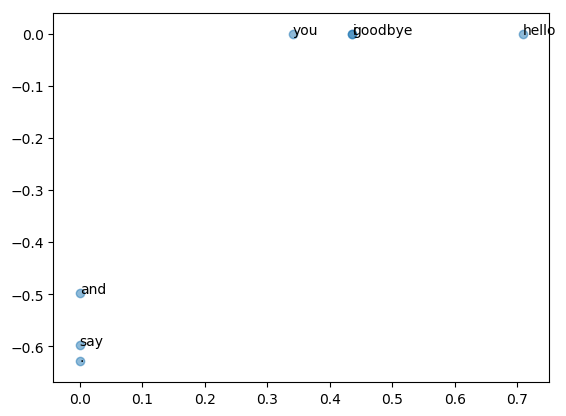

PyObject <matplotlib.collections.PathCollection object at 0x0000000035055278>

In [80]:
figure()
for (word, wid) in word_to_id
    annotate(word, (U[wid, 1], U[wid, 2]))
end
scatter(U[:, 1], U[:, 2], alpha=0.5)